<a href="https://colab.research.google.com/github/AmirAflak/AI-P4/blob/main/Snake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
src = list(files.upload().values())[0]
open('replay_buffer.py','wb').write(src)
import replay_buffer

Saving replay_buffer.py to replay_buffer.py


In [2]:
from google.colab import files
src = list(files.upload().values())[0]
open('Game.py','wb').write(src)
import Game

Saving Game.py to Game.py


In [3]:
from google.colab import files
src = list(files.upload().values())[0]
open('model.py','wb').write(src)
import model

Saving model.py to model.py


In [4]:
import torch
import torch.nn as nn

import numpy as np

torch.manual_seed(0)
np.random.seed(0)

In [5]:
from model import QNetwork, get_network_input
from Game import GameEnvironment
from collections import deque
from replay_buffer import ReplayMemory
import time

# TODO: Create an instance for model with input_dim = 10, hidden_dim = 20, output_dim = 5

model = QNetwork(input_dim=10, hidden_dim=20, output_dim=5).float()


epsilon = 0.1
grid_size = 15
GAMMA = 0.9

board = GameEnvironment(grid_size, nothing=0, dead=-1, apple=1)
memory = ReplayMemory(1000)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)

In [6]:
import numpy as np
import torch
import random

def run_episode(num_games):
    run = True
    games_played = 0
    total_reward = 0
    episode_games = 0
    snake_len_array = []

    while run:
        # Get current state
        state = get_network_input(board.snake, board.apple).float()

        # Forward pass through the model to get Q-values for the current state
        action_q_values = model(state.unsqueeze(0))  # Add batch dimension
        action_0 = torch.argmax(action_q_values).item()  # Choose the action with the highest Q-value
        # Epsilon-greedy strategy
        if random.random() < epsilon:
            next_action = random.randint(0, 4)  # Explore: select a random action
        else:
            next_action = action_0  # Exploit: select the action with the highest Q-value

        reward, done, len_of_snake = board.update_board_state(next_action)

        # Get next state
        next_state = get_network_input(board.snake, board.apple)

        memory.push(state, next_action, reward, next_state, done)

        # Update total reward
        total_reward += reward

        episode_games += 1

        if board.game_over:
            games_played += 1
            snake_len_array.append(len_of_snake)
            board.reset_game()

            if num_games == games_played:
                run = False

    avg_len_of_snake = np.mean(snake_len_array)
    max_len_of_snake = np.max(snake_len_array)
    return total_reward, avg_len_of_snake, max_len_of_snake


In [7]:
MSE = nn.MSELoss()
def learn(num_updates, batch_size):
    total_loss = 0

    for i in range(num_updates):
        optimizer.zero_grad()
        sample = memory.sample(batch_size)

        states, actions, rewards, next_states, dones = sample

        # Convert to PyTorch tensors
        states = torch.cat([x.unsqueeze(0) for x in states], dim=0).float()
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.cat([x.unsqueeze(0) for x in next_states], dim=0).float()
        dones = torch.FloatTensor(dones)

        # Get Q values for current state
        q_local = model(states)

        # Get Q values for next state
        next_q_values = model(next_states)

        # Gather the Q values corresponding to the taken actions
        Q_expected = q_local.gather(1, actions.unsqueeze(1)).squeeze(1)

        # Calculate max Q value for next state from target model
        Q_targets_next = next_q_values.max(dim=1)[0].detach()

        # Calculate Q targets for current states using Bellman equation
        Q_targets = rewards + (GAMMA * Q_targets_next * (1 - dones))

        # Calculate loss
        loss = MSE(Q_expected, Q_targets)

        # Perform a backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss


In [8]:
!ls

Game.py  model	model.py  __pycache__  replay_buffer.py  sample_data


In [9]:
num_episodes = 3000
num_updates = 200
print_every = 100
games_in_episode = 30
batch_size = 20


def train():
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []

    avg_len_array = []
    avg_max_len_array = []

    time_start = time.time()

    for i_episode in range(1, num_episodes + 1):

        # Run an episode
        score, avg_len, max_len = run_episode(games_in_episode)

        scores_deque.append(score)
        scores_array.append(score)
        avg_len_array.append(avg_len)
        avg_max_len_array.append(max_len)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)

        # Learn from the episode
        total_loss = learn(num_updates, batch_size)

        dt = (int)(time.time() - time_start)

        if i_episode % print_every == 0:
            print('Ep.: {:6}, Loss: {:.3f}, Avg.Score: {:.2f}, Avg.LenOfSnake: {:.2f}, Max.LenOfSnake:  {:.2f} Time: {:02}:{:02}:{:02} '.\
                  format(i_episode, total_loss, avg_score, avg_len, max_len, dt//3600, dt%3600//60, dt%60))

        memory.truncate()

        if i_episode % 250 == 0:
            torch.save(model.state_dict(), './model/Snake_{}'.format(i_episode))

    return scores_array, avg_scores_array, avg_len_array, avg_max_len_array

# Train the model
scores, avg_scores, avg_len_of_snake, max_len_of_snake = train()


Ep.:    100, Loss: 4.183, Avg.Score: -28.50, Avg.LenOfSnake: 5.00, Max.LenOfSnake:  5.00 Time: 00:01:10 
Ep.:    200, Loss: 3.548, Avg.Score: -27.14, Avg.LenOfSnake: 5.10, Max.LenOfSnake:  6.00 Time: 00:02:33 
Ep.:    300, Loss: 2.829, Avg.Score: -24.84, Avg.LenOfSnake: 5.13, Max.LenOfSnake:  7.00 Time: 00:04:27 
Ep.:    400, Loss: 4.279, Avg.Score: -25.31, Avg.LenOfSnake: 5.17, Max.LenOfSnake:  7.00 Time: 00:06:25 
Ep.:    500, Loss: 3.856, Avg.Score: -24.76, Avg.LenOfSnake: 5.23, Max.LenOfSnake:  8.00 Time: 00:08:23 
Ep.:    600, Loss: 3.527, Avg.Score: -24.17, Avg.LenOfSnake: 5.30, Max.LenOfSnake:  7.00 Time: 00:10:24 
Ep.:    700, Loss: 2.921, Avg.Score: -23.86, Avg.LenOfSnake: 5.27, Max.LenOfSnake:  8.00 Time: 00:12:26 
Ep.:    800, Loss: 2.784, Avg.Score: -22.42, Avg.LenOfSnake: 5.20, Max.LenOfSnake:  8.00 Time: 00:14:34 
Ep.:    900, Loss: 3.476, Avg.Score: -20.39, Avg.LenOfSnake: 5.63, Max.LenOfSnake:  9.00 Time: 00:16:49 
Ep.:   1000, Loss: 3.225, Avg.Score: -17.89, Avg.LenOfS

length of scores:  3000 , len of avg_scores:  3000


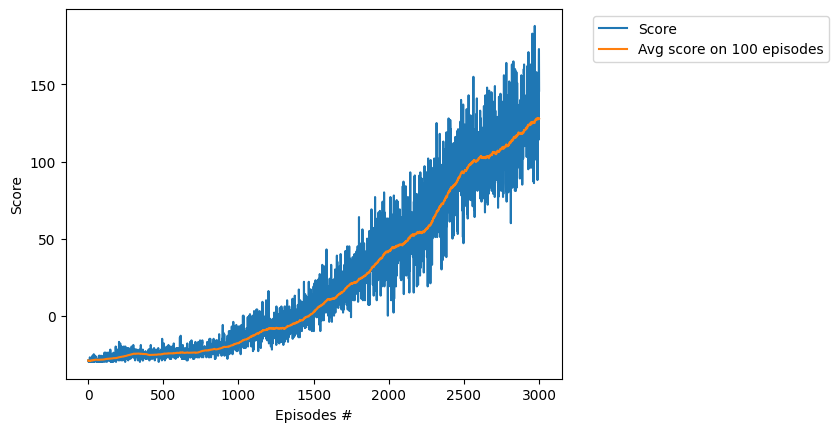

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg score on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

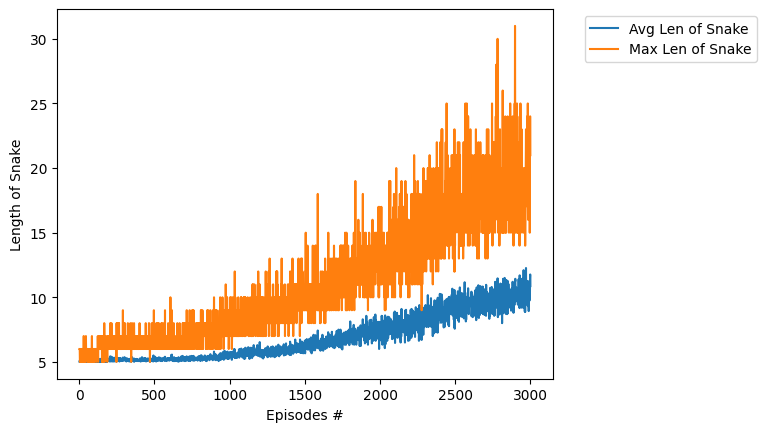

In [11]:
ax1 = fig.add_subplot(121)
plt.plot(np.arange(1, len(avg_len_of_snake)+1), avg_len_of_snake, label="Avg Len of Snake")
plt.plot(np.arange(1, len(max_len_of_snake)+1), max_len_of_snake, label="Max Len of Snake")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.ylabel('Length of Snake')
plt.xlabel('Episodes #')
plt.show()